<a href="https://colab.research.google.com/github/golendum/Pyannote_Pipeline_Finetuning/blob/main/tutorials/adapting_pretrained_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adapting pyannote.audio 2.1 pretrained speaker diarization pipeline to your own data

> "How I reached 1st place at Ego4D 2022, 1st place at Albayzin 2022, and 6th place at VoxSRC 2022 speaker diarization challenges"

[pyannote.audio](https://github.com/pyannote/pyannote-audio) is an open-source toolkit written in Python for speaker diarization.

Version 2.1 introduces a major overhaul of the default speaker diarization pipeline, made of three main stages: speaker segmentation applied to a short sliding window, neural speaker embedding of each (local) speakers, and (global) agglomerative clustering.

Despite its decent out-of-the-box performance, the default pipeline may suffer from the domain mismatch problem (common to most machine learning models) and not perform well on your own data. This tutorial will guide you through two recipes to adapt it to your own data and (hopefully) get better performance. Depending on the number and duration of labeled conversations, you may either focus on optimizing hyper-parameters or additionally fine-tune the internal speaker segmentation model.

⚠ Make sure that you switch to a GPU runtime (Runtime > Change runtime type).  
If you don't, everything will be extremely slow.

## Installation


In [4]:
!pip install pyannote.audio==3.1.1
!pip install -qq rich

⚠ Restart the runtime (Runtime > Restart session).  
If you don't, `pyannote.database` will throw an error below.

## Data preparation

First things first: we need data... Annotated data! Ideally, lots of annotated data!

For the purpose of this tutorial, we will rely on the AMI-SDM (single distance microphone) corpus.


In [1]:
# download AMI-SDM mini corpus
%cd /content/
!git clone https://github.com/pyannote/AMI-diarization-setup
%cd /content/AMI-diarization-setup/pyannote/
!bash download_ami_sdm_mini.sh

/content
fatal: destination path 'AMI-diarization-setup' already exists and is not an empty directory.
/content/AMI-diarization-setup/pyannote


In [2]:
!PYANNOTE_DATABASE_CONFIG="/content/AMI-diarization-setup/pyannote/database.yml" pyannote-database info AMI-SDM.SpeakerDiarization.mini

'AMI-SDM.SpeakerDiarization.only_words' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI-SDM.SpeakerDiarization.mini' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.only_words' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.mini' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.word_and_vocalsounds' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI-SDM.SpeakerDia

Note that we use a "mini" version of AMI-SDM so that the tutorial can be run in half an hour but the full version is also available for you to get better results.

If you want to try it, replace `download_ami_sdm_mini.sh` by `download_ami_sdm.sh` and `AMI-SDM.SpeakerDiarization.mini` by `AMI-SDM.SpeakerDiarization.only_words` and you are good to go!

In [3]:
!ls -R /content/AMI-diarization-setup

/content/AMI-diarization-setup:
LICENSE  lists	only_words  pyannote  README.md  uems  word_and_vocalsounds

/content/AMI-diarization-setup/lists:
dev.meetings.txt  dev.speakers.txt   test.mini.txt	train.meetings.txt  train.speakers.txt
dev.mini.txt	  test.meetings.txt  test.speakers.txt	train.mini.txt

/content/AMI-diarization-setup/only_words:
labs  rttms

/content/AMI-diarization-setup/only_words/labs:
dev  test  train

/content/AMI-diarization-setup/only_words/labs/dev:
ES2011a.lab  ES2011d.lab  IB4003.lab  IB4011.lab   IS1008c.lab	TS3004b.lab
ES2011b.lab  IB4001.lab   IB4004.lab  IS1008a.lab  IS1008d.lab	TS3004c.lab
ES2011c.lab  IB4002.lab   IB4010.lab  IS1008b.lab  TS3004a.lab	TS3004d.lab

/content/AMI-diarization-setup/only_words/labs/test:
EN2002a.lab  EN2002d.lab  ES2004c.lab  IS1009b.lab  TS3003a.lab  TS3003d.lab
EN2002b.lab  ES2004a.lab  ES2004d.lab  IS1009c.lab  TS3003b.lab
EN2002c.lab  ES2004b.lab  IS1009a.lab  IS1009d.lab  TS3003c.lab

/content/AMI-diarization-setup/only_w

In [4]:
from pyannote.database import registry, FileFinder

registry.load_database("/content/AMI-diarization-setup/pyannote/database.yml")
dataset = registry.get_protocol("AMI-SDM.SpeakerDiarization.mini", {"audio": FileFinder()})

'AMI-SDM.SpeakerDiarization.only_words' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI-SDM.SpeakerDiarization.mini' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.only_words' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.mini' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.word_and_vocalsounds' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI-SDM.SpeakerDia

/usr/local/lib/python3.11/dist-packages/pyannote/database/registry.py:499: UserWarning: Replacing existing AMI-SDM.SpeakerDiarization.only_words protocol by the one defined in '/content/AMI-diarization-setup/pyannote/database.yml'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pyannote/database/registry.py:499: UserWarning: Replacing existing AMI-SDM.SpeakerDiarization.mini protocol by the one defined in '/content/AMI-diarization-setup/pyannote/database.yml'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pyannote/database/registry.py:499: UserWarning: Replacing existing AMI.SpeakerDiarization.only_words protocol by the one defined in '/content/AMI-diarization-setup/pyannote/database.yml'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pyannote/database/registry.py:499: UserWarning: Replacing existing AMI.SpeakerDiarization.mini protocol by the one defined in '/content/AMI-diarization-setup/pyannote/database.yml'.
  warnings.warn(
/usr/local/lib/python3.1

## Pretrained pipeline

Let's start by running the pretrained pipeline on the test set and evaluate its performance.

Official [pyannote.audio](https://github.com/pyannote/pyannote-audio) pipelines (i.e. those under the [`pyannote` organization](https://hf.co/pyannote) umbrella) are open-source, but gated. It means that you have to first accept users conditions on their respective Huggingface page to access the pretrained weights and hyper-parameters.

To load the speaker diarization pipeline used in this tutorial, you have to
* visit [hf.co/pyannote/speaker-diarization](https://hf.co/pyannote/speaker-diarization) and accept the terms
* visit [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation) (used internally by the speaker diarization pipeline)and accept the terms
* log in using `notebook_login`

In [18]:
from huggingface_hub import login
login()

In [20]:
from pyannote.audio import Pipeline
pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=True)


pytorch_model.bin:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/318 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
import itertools

metric = DiarizationErrorRate()

# Limit to 10 files to test if iteration works
test_files = itertools.islice(dataset.test(), 10)

for idx, file in enumerate(test_files):
    print(f"Processing file {idx+1}...")  # Debugging print

    try:
        # Apply pretrained pipeline
        file["pretrained pipeline"] = pretrained_pipeline(file)

        # Evaluate performance
        metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

        print(f"File {idx+1} processed successfully.")  # Confirm progress

    except Exception as e:
        print(f"Error processing file {idx+1}: {e}")  # Catch errors and continue

print(f"The pretrained pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

In [1]:
# this takes approximately 2min to run on Google Colab GPU
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

for file in dataset.test():
    # apply pretrained pipeline
    file["pretrained pipeline"] = pretrained_pipeline(file)

    # evaluate its performance
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"The pretrained pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

ModuleNotFoundError: No module named 'pyannote'

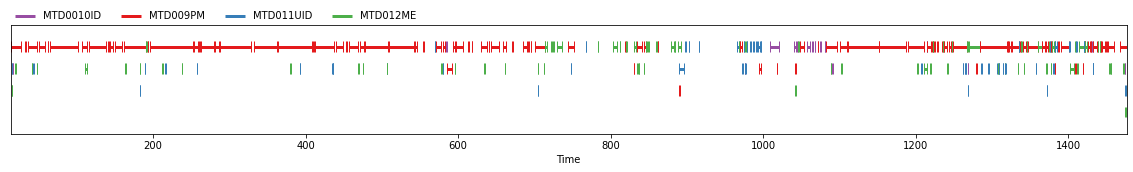

In [ ]:
file["annotation"]

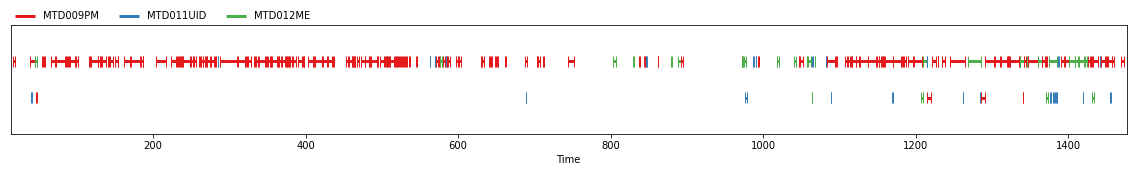

In [ ]:
file["pretrained pipeline"]

## Fine-tuning the segmentation model

When a sufficiently large training set of labeled conversations is available, fine-tuning the internal speaker segmentation model may lead to significant performance boost.

Starting from the pretrained model...

In [ ]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation", token=True)

... we prepare it for fine-tuning on the training dataset:

In [ ]:
from pyannote.audio.tasks import Segmentation
task = Segmentation(
    dataset,
    duration=model.specifications.duration,
    max_num_speakers=len(model.specifications.classes),
    batch_size=32,
    num_workers=2,
    loss="bce",
    vad_loss="bce")
model.task = task
model.prepare_data()
model.setup()

The actual training is done with [`lightning`](https://github.com/Lightning-AI/lightning):

In [ ]:
# this takes approximately 15min to run on Google Colab GPU
from types import MethodType
from torch.optim import Adam
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)

# we use Adam optimizer with 1e-4 learning rate
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)

model.configure_optimizers = MethodType(configure_optimizers, model)

# we monitor diarization error rate on the validation set
# and use to keep the best checkpoint and stop early
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor=monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False,
)
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False,
)

callbacks = [RichProgressBar(), checkpoint, early_stopping]

# we train for at most 20 epochs (might be shorter in case of early stopping)
from pytorch_lightning import Trainer
trainer = Trainer(accelerator="gpu",
                  callbacks=callbacks,
                  max_epochs=20,
                  gradient_clip_val=0.5)
trainer.fit(model)

In [ ]:
# save path to the best checkpoint for later use
finetuned_model = checkpoint.best_model_path

# uncomment to download the checkpoint
#from google.colab import files
#files.download(finetuned_model)

## Optimizing the pipeline hyper-parameters

The pretrained `pyannote/speaker-diarization` pipeline relies on its own set of hyper-parameters adapted to the internal `pyannote/segmentation` pretrained model:

In [ ]:
pretrained_hyperparameters = pretrained_pipeline.parameters(instantiated=True)
pretrained_hyperparameters

{'segmentation': {'min_duration_off': 0.5817029604921046,
  'threshold': 0.4442333667381752},
 'clustering': {'method': 'centroid',
  'min_cluster_size': 15,
  'threshold': 0.7153814381597874}}

There is no reason the above hyper-parameters are optimal for the newly finetuned speaker segmentation model. Let's optimize them:

* `segmentation.threshold` ($\theta$  in the [technical report](https://huggingface.co/pyannote/speaker-diarization/resolve/main/technical_report_2.1.pdf), between 0 and 1) controls the aggressiveness of speaker activity detection (i.e. a higher value will result in less detected speech);
* `clustering.threshold` ($\delta$  in the report, between 0 and 2) controls the number of speakers (i.e. a higher value will result in less speakers).
* `segmentation.min_duration_off` ($\Delta$ in the report, in seconds) controls whether intra-speaker pauses are filled. This usually depends on the downstream application so it is better to first force it to zero (i.e. never fill intra-speaker pauses) during optimization.
* `clustering.centroid` is the linkage used by the agglomerative clustering step. `centroid` has been found to be slightly better than `average`.
* `clustering.min_cluster_size` controls what to do with small speaker clusters. Clusters smaller than that are assigned to the most similar large cluster. `15` is a good default value.

We start by optimizing `segmentation.threshold` by assuming that the subsequent clustering step is perfect (cf. `OracleClustering`).

In [ ]:
# this takes approximately 5min to run on Google Colab GPU
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.pipeline import Optimizer

pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    clustering="OracleClustering",
)
# as reported in the technical report, min_duration_off can safely be set to 0.0
pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

optimizer = Optimizer(pipeline)
dev_set = list(dataset.development())

iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
    if i > 20: break   # 50 iterations should give slightly better results

Then, we use the optimized value of `segmentation.threshold` and optimize `clustering.threshold`.

In [ ]:
best_segmentation_threshold = optimizer.best_params["segmentation"]["threshold"]

In [ ]:
# this takes approximately 5min to run on Google Colab GPU
pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

pipeline.freeze({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
    },
})

optimizer = Optimizer(pipeline)
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best clustering threshold so far: {iteration['params']['clustering']['threshold']}")
    if i > 20: break  # 50 iterations should give slightly better results

Finally, we use the optimized values of `segmentation.threshold` and `clustering.threshold` to evaluate the performance of the finetuned pipeline:

In [ ]:
best_clustering_threshold = optimizer.best_params['clustering']['threshold']

In [ ]:
# this takes approximately 2min to run on Google Colab GPU
finetuned_pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

finetuned_pipeline.instantiate({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
        "threshold": best_clustering_threshold,
    },
})

metric = DiarizationErrorRate()

for file in dataset.test():
    # apply finetuned pipeline
    file["finetuned pipeline"] = finetuned_pipeline(file)

    # evaluate its performance
    metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])

print(f"The finetuned pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

The finetuned pipeline reaches a Diarization Error Rate (DER) of 26.6% on AMI-SDM.SpeakerDiarization.mini test set.


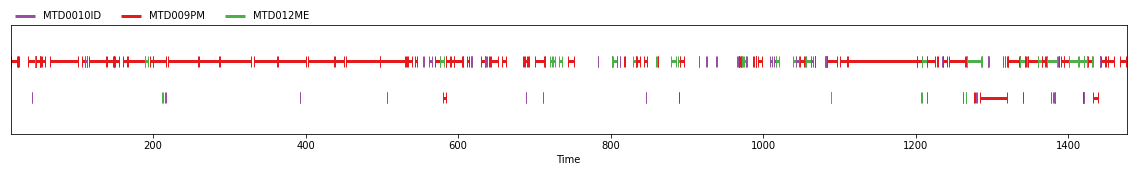

In [ ]:
file["finetuned pipeline"]

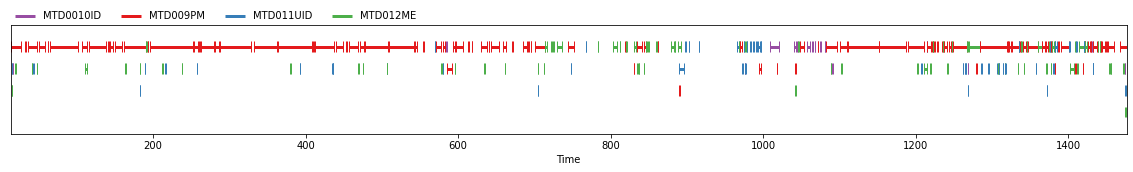

In [ ]:
file["annotation"]

## Conclusion

In just about half an hour (and 6 hours of training data), we managed to reduce the diarization error rate from 32.5% to 26.6%.

[Yours truly](https://herve.niderb.fr) used this very recipe for their submissions to several speaker diarization benchmarks organized in 2022. I reached:

* 6th place at [VoxSRC 2022](https://mm.kaist.ac.kr/datasets/voxceleb/voxsrc) speaker diarization challenge
* 1st place at [Ego4D 2022](https://ego4d-data.org/) audio-only speaker diarization challenge
* 1st place at [Albayzin 2022](http://catedrartve.unizar.es/albayzin2022results.html) speaker diarization challenge

The [technical report](https://huggingface.co/pyannote/speaker-diarization/resolve/main/technical_report_2.1.pdf) contains a detailed description of the pipeline, as well as an extensive evaluation of its performance on multiple benchmarking datasets.

For technical questions and bug reports, please check [pyannote.audio](https://github.com/pyannote/pyannote-audio) Github repository so that my (or anyone's) public answer benefits other people as well.

For scientific consulting enquiries, please contact [me](herve@niderb.fr).